# Clustering of voxels and ROI based on beta maps

## Importing

In [18]:
import os
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import nistats
import scipy
import seaborn as sns
import nibabel as nib
import nilearn
from nilearn.image import load_img, mean_img, index_img, threshold_img, math_img, smooth_img, new_img_like
from nilearn.regions import RegionExtractor
from nilearn import plotting
from nilearn import datasets
from scipy.stats import norm
from nilearn.surface import vol_to_surf
from utils import *
import hdbscan
import umap
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import FastICA 
from sklearn import manifold
from sklearn.neighbors import kneighbors_graph

In [19]:
from logger import Logger
from utils import read_yaml, check_folder, fetch_masker, possible_subjects_id, get_subject_name
import reporting
from linguistics_info import load_surnames, load_syntactic_roi, load_language_roi

## Defining global variables

In [20]:
language = 'english'

In [21]:
PROJECT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/"
OUTPUT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/{language}"
INPUT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{language}"
FMRIDATA_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/fMRI/{language}"
MASKER_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/global_masker_95%_{language}"
SMOOTHED_MASKER_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/smoothed_global_masker_{language}"

In [22]:
PROJECT_PATH = f"/Users/alexpsq/Code/Parietal/maps"

In [23]:
logger = Logger(os.path.join(PROJECT_PATH, 'logs.txt'))

In [24]:
#path_to_beta_maps = "/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english/{subject_name}/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{subject_id}_hidden-all-layers/{subject_name}_bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{subject_id}_hidden-all-layers_coef_.npy"
#mask = "/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english/{subject_name}/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{subject_id}_hidden-all-layers/{subject_name}_bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{subject_id}_hidden-all-layers_R2.nii.gz"
path_to_beta_maps_template = "/Users/alexpsq/Code/Parietal/maps/{subject_name}_bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{subject_id}_hidden-all-layers_coef_.npy"
mask_template = "/Users/alexpsq/Code/Parietal/maps/{subject_name}_bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{subject_id}_hidden-all-layers_R2.nii.gz"

In [25]:
saving_folder = "/Users/alexpsq/Code/Parietal/maps/"

In [114]:
all_reduction_method = ["none", "umap", "pca", "ica", "isomap", "mds", "sp-emb"]
all_clustering_method = ["hdbscan", "agg-clus", "max"]

In [167]:
params = {
        'path_to_beta_maps':None, 
        'reduction':None, 
        'clustering':None, 
        'mask':None, 
        'global_mask':None, 
        'atlas_maps':None, 
        'labels':None, 
        'min_cluster_size':20, 
        'min_samples':10, 
        'n_neighbors':30, 
        'min_dist':0.0, 
        'n_components':10, 
        'n_clusters':13, 
        'random_state':1111, 
        'cluster_selection_epsilon':0.0, 
        'affinity_reduc' : 'nearest_neighbors',
        'affinity_cluster':'cosine', 
        'linkage':'average',
        'saving_folder': None,
        'plot_name': None
}

## Functions definition

In [55]:
def heat_map(path_to_beta_maps, aggregate=False, title='', saving_path=None):
    if isinstance(path_to_beta_maps, str):
        data = np.load(path_to_beta_maps)
    else:
        data = path_to_beta_maps
    plt.figure(figsize=(40,40))
    if aggregate:
        data = aggregate_beta_maps(data, nb_layers=13, layer_size=768)
    sns.heatmap(data)
    plt.title('Heatmap -', title)
    if saving_path is not None:
        plt.savefig(saving_path)
        plt.close()
    else:
        plt.show()

In [56]:
def resample_beta_maps(path_to_beta_maps, original_masker, new_masker):
    """Resample beta map with a new masker.
    path_to_beta_maps: #voxels x #features"""
    if isinstance(original_masker, str):
        original_masker = load_masker(original_masker)
    if isinstance(new_masker, str):
        new_masker = load_masker(new_masker)
    if isinstance(path_to_beta_maps, str):
        data = np.load(path_to_beta_maps)
    else:
        data = path_to_beta_maps
    print("Original data has dimension: ", data.shape)
    imgs = original_masker.inverse_transform([data[:, i] for i in range(data.shape[1])])
    new_data = new_masker.transform(imgs) # dimension: #samples x #voxels
    print("New data has dimension: ", new_data.T.shape)
    return new_data.T
    

In [57]:
def create_subject_mask(mask_template, subject_name, subject_id, global_masker, threshold=75):
    mask_img = nib.load(mask_template.format(subject_name=subject_name, subject_id=subject_id))
    mask_tmp = global_masker.transform(mask_img)
    mask = np.zeros(mask_tmp.shape)
    mask[mask_tmp > np.percentile(mask_tmp, threshold)] = 1
    mask = mask.astype(int)
    mask = mask[0].astype(bool)
    return mask

In [58]:
def aggregate_beta_maps(data, nb_layers=13, layer_size=768):
    """Clustering of voxels or ROI based on their beta maps.
    maps: (#voxels x #features)
    """
    if isinstance(data, str):
        data = np.load(data)
    nb_layers = nb_layers
    layer_size = layer_size
    result = np.zeros((data.shape[0], nb_layers))
    for index in range(nb_layers):
        result[:, index] = np.mean(data[:, layer_size * index : layer_size * (index + 1)], axis=1)
    return result

In [59]:
def plot_roi_img_surf(surf_img, saving_path, plot_name, mask=None, labels=None, inflated=False, compute_surf=True, colorbar=True, **kwargs):
    fsaverage = datasets.fetch_surf_fsaverage()
    if compute_surf:
        surf_img = vol_to_surf(surf_img, fsaverage[kwargs['surf_mesh']], interpolation='nearest', mask_img=mask)
        surf_img[np.isnan(surf_img)] = -2
    if labels is not None:
        surf_img = np.round(surf_img)
        
    surf_img += 2
    plt.close('all')
    plt.hist(surf_img, bins=50)
    plt.title(plot_name)
    plt.savefig(saving_path + "hist_{}.png".format(plot_name))
    plt.close('all')
    if inflated:
        kwargs['surf_mesh'] = 'infl_left' if 'left' in kwargs['surf_mesh_type'] else 'infl_right' 
    disp = plotting.plot_surf_roi(
        surf_mesh=fsaverage[kwargs['surf_mesh']], 
        roi_map=surf_img,
        hemi=kwargs['hemi'],
        view=kwargs['view'],
        bg_map=fsaverage[kwargs['bg_map']], 
        bg_on_data=kwargs['bg_on_data'],
        darkness=kwargs['darkness'],
        colorbar=colorbar)
    if saving_path:
        disp.savefig(saving_path + plot_name + '_{}_{}_{}.png'.format(kwargs['surf_mesh_type'], kwargs['hemi'], kwargs['view']))
    else:
        plotting.show()

In [60]:
def scatter3d(data, cs, colorsMap='jet', reduction_type='', other=None, **kwargs):
    """3D scatter plot with random color to distinguish the shape."""
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], marker='o', c=scalarMap.to_rgba(cs), **kwargs)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.view_init(other['elevation'], other['azimuth'])

    #ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
    scalarMap.set_array(cs)
    fig.colorbar(scalarMap)
    plt.title('Activations embedding for {}'.format(reduction_type), fontsize=24)
    ax.view_init(other['elevation'], other['azimuth'])
    interact()

In [61]:
def plot_reduction(data, plot_type='2D', reduction_type='', other=None, **kwargs):
    """kwargs includes: 
     - s=5
     - c='density'
     - cmap='Spectral'
    """
    plt.close('all')
    if plot_type=='2D':
        plt.scatter(data[:, 0], data[:, 1], **kwargs)
        interact()
    elif plot_type=='3D':
        scatter3d(data, results, colorsMap='jet', reduction_type=reduction_type, other=other, **kwargs)

In [62]:
def plot_reduc(path_to_beta_maps, n_neighbors=30, min_dist=0.0, n_components=3, random_state=1111, cluster_selection_epsilon=0.0):
    """Clustering of voxels or ROI based on their beta maps.
    """
    if isinstance(path_to_beta_maps, str):
        data = np.load(path_to_beta_maps).T
    else:
        data = path_to_beta_maps.T
    
    plot_kwargs = {
        's':2,
        #'c':'density',
        'cmap':'Spectral'
    }
    data = data.T
    print("UMAP...")
    umap_result_3D = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=random_state, metric='manhattan').fit_transform(data)
    plot_reduction(umap_result_3D, plot_type='3D', reduction_type='UMAP', other={'elevation': 15, 'azimuth': 15}, **plot_kwargs)
    

In [172]:
def clustering(path_to_beta_maps, reduction, clustering, mask=None, global_mask=None, atlas_maps=None, labels=None, min_cluster_size=20, min_samples=10, n_neighbors=30, min_dist=0.0, n_components=10, n_clusters=13, random_state=1111, cluster_selection_epsilon=0.0, affinity_reduc='nearest_neighbors', affinity_cluster='cosine', linkage='average', saving_folder=None, plot_name=None):
    """Clustering of voxels or ROI based on their beta maps.
    """
    if isinstance(path_to_beta_maps, str):
        data = np.load(path_to_beta_maps).T
    else:
        data = path_to_beta_maps.T
    if global_mask and atlas_maps:
        global_masker = load_masker(global_mask)
        imgs = global_masker.inverse_transform([data[i, :] for i in range(data.shape[0])])
        data = np.zeros((data.shape[0], len(labels)-1))
        for index_mask in tqdm(range(len(labels)-1)):
            masker = get_roi_mask(atlas_maps, index_mask, labels, global_mask=global_mask)
            data[:, index_mask] = np.mean(masker.transform(imgs), axis=1)
    data = data.T
    data_ = data[mask, :] if mask is not None else data.copy()
    
    if reduction=="umap":
        data_reduced = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=random_state, metric='cosine').fit_transform(data_)
        standard_embedding = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=random_state, metric='cosine').fit_transform(data_)
    elif reduction=="pca":
        data_reduced = PCA(n_components=n_components, random_state=random_state).fit_transform(data_)
        standard_embedding = PCA(n_components=2, random_state=random_state).fit_transform(data_)
    elif reduction=="ica":
        data_reduced = FastICA(n_components=n_components, random_state=random_state).fit_transform(data_)
        standard_embedding = FastICA(n_components=2, random_state=random_state).fit_transform(data_)
    elif reduction=="isomap":
        data_reduced = manifold.Isomap(n_components=n_components, n_neighbors=n_neighbors, n_jobs=-1).fit_transform(data_)
        standard_embedding = manifold.Isomap(n_components=2, n_neighbors=n_neighbors, n_jobs=-1).fit_transform(data_)
    elif reduction=="mds":
        data_reduced = manifold.MDS(n_components=n_components, random_state=random_state, n_jobs=-1).fit_transform(data_)
        standard_embedding = manifold.MDS(n_components=2, random_state=random_state, n_jobs=-1).fit_transform(data_)
    elif reduction=="sp-emb":
        data_reduced = manifold.SpectralEmbedding(n_components=n_components, random_state=random_state, n_neighbors=n_neighbors, n_jobs=-1).fit_transform(data_)
        standard_embedding = manifold.SpectralEmbedding(n_components=2, random_state=random_state, n_neighbors=n_neighbors, n_jobs=-1, affinity=affinity_reduc).fit_transform(data_)
    else:
        data_reduced = data_
    if clustering=='hdbscan':
        labels_ = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size, cluster_selection_epsilon=cluster_selection_epsilon).fit_predict(data_reduced)
    elif clustering=='agg-clus':
        #kneighbors_graph_ = kneighbors_graph(data_, n_neighbors=5)
        sc = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, affinity=affinity_cluster) #  connectivity=kneighbors_graph_
        clustering = sc.fit(data_reduced)
        labels_ = clustering.labels_
    elif clustering=="max":
        labels_ = np.argmax(data_reduced, axis=1)
    all_labels = np.zeros(data.shape[0])
    all_labels[mask] = labels_
    all_labels[~mask] = -2
    
    # Printing scatter plot
    if reduction in ["umap", "pca", "ica", "isomap", "mds", "sp-emb"]:
        plt.close('all')
        clustered = (labels_ >= 0)
        colorsMap='jet'
        cm = plt.get_cmap(colorsMap)
        cNorm = matplotlib.colors.Normalize(vmin=min(labels_), vmax=max(labels_))
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

        plt.scatter(standard_embedding[clustered, 0],
                    standard_embedding[clustered, 1],
                    c=scalarMap.to_rgba(labels_[clustered]),
                    s=0.1,
                    cmap='Spectral')
        plot_name += '_nb_clusters-{}_non-null-{}'.format(len(np.unique(all_labels)), np.sum(all_labels>0))
        plt.title(plot_name)
        check_folder(saving_folder)
        if saving_folder is not None:
            plt.savefig(saving_folder + "scatter_{}.png".format(plot_name))
        plt.show()
        plt.close('all')
        
    return all_labels

In [205]:
def create_name(subject_name, params):
    keys = [
            'reduction',
            'clustering',
            'min_cluster_size',
            'n_neighbors',
            'n_components',
            'affinity_reduc',
            'affinity_cluster',
            'linkage'
    ]
    name = subject_name
    for key in keys:
        name += '_' + key + '-' + str(params[key])
    return name

In [156]:
def save_results(results, saving_folder, plot_name, global_masker, mask, **kwargs):
    """Save surface plot."""
    plot_name += '_nb_clusters-{}_non-null-{}'.format(len(np.unique(results)), np.sum(results>0))
    check_folder(os.path.join(saving_folder, 'labels'))
    np.save(os.path.join(saving_folder, 'labels', plot_name+'.npy'), results)
    img = global_masker.inverse_transform(results)
    plot_roi_img_surf(img, saving_folder, plot_name, mask=global_masker.inverse_transform(mask), labels=np.unique(results), inflated=False, compute_surf=True, colorbar=True, **kwargs)


In [208]:
def get_prob_matrix(labels):
    nb_voxels = len(labels)
    nb_clusters = len(np.unique(labels))
    prob_matrix = np.zeros((nb_clusters, nb_voxels))
    for index, i in enumerate(np.unique(labels)):
        prob_matrix[index, labels==i] = 1
    return prob_matrix

In [179]:
def get_labels(subject_name, reduction, clustering, saving_folder, params):
    """Retrieve computed labels for a given subject."""
    saving_folder = os.path.join(saving_folder, '_'.join([reduction, clustering]) + '/')
    plot_name = create_name(subject_name, params)
    path = sorted(glob.glob(os.path.join(saving_folder, 'labels', plot_name + '*.npy')))
    print(os.path.join(saving_folder, 'labels', plot_name + '*.npy'))
    return path

## Data Loading

In [158]:
global_masker_50 = reporting.fetch_masker(f"{PROJECT_PATH}/global_masker_{language}"
, language, FMRIDATA_PATH, INPUT_PATH, smoothing_fwhm=None, logger=logger)
global_masker_95 = reporting.fetch_masker(f"{PROJECT_PATH}/global_masker_95%_{language}"
, language, FMRIDATA_PATH, INPUT_PATH, smoothing_fwhm=None, logger=logger)

In [159]:
atlas_maps, labels = reporting.load_atlas() # load harvard-oxford atlas named'cort-prob-2mm'
x_labels = labels[1:]

In [160]:
subjects = [get_subject_name(sub_id) for sub_id in possible_subjects_id(language)]

In [161]:
#reporting.plot_roi_img_surf(global_masker_50.inverse_transform(global_masker_50.transform("/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english/sub-057/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_57_hidden-all-layers/sub-057_bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_57_hidden-all-layers_R2.nii.gz")), None, 'test', inflated=False, compute_surf=True, colorbar=True, **kwargs)


## Defining subjects variables

In [162]:
subject_name="sub-057"
subject_id="57"
original_masker = global_masker_50
new_masker = global_masker_95
original_masker.set_params(detrend=False, standardize=False)
new_masker.set_params(detrend=False, standardize=False)

NiftiMasker(detrend=False, dtype=None, high_pass=None, low_pass=None,
            mask_args=None,
            mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f9197898990>,
            mask_strategy='background', memory=Memory(location=None),
            memory_level=0, reports=True, sample_mask=None, sessions=None,
            smoothing_fwhm=None, standardize=False, t_r=None,
            target_affine=None, target_shape=None, verbose=0)

In [163]:
path_to_beta_maps = path_to_beta_maps_template.format(subject_name=subject_name, subject_id=subject_id)
mask = create_subject_mask(mask_template, subject_name, subject_id, global_masker_95, threshold=75)

In [164]:
view = 'left' #left
kwargs = {
    'surf_mesh': f'pial_{view}', # pial_right, infl_left, infl_right
    'surf_mesh_type': f'pial_{view}',
    'hemi': view, # right
    'view':'lateral', # medial
    'bg_map': f'sulc_{view}', # sulc_right
    'bg_on_data':True,
    'darkness':.05
}

In [165]:
# Parameters
n_components_list = [3, 5, 10, 13]
n_clusters_list = [3, 6, 9, 13, 15]
min_samples = 1 # [1, 5, 10]
min_cluster_size = 30 # [ 30, 10, 5]
n_neighbors = 30
n_components = 10
n_clusters = 13
cluster_selection_epsilon = 0.5
min_dist = 0.0
affinity_list_SE = ['nearest_neighbors', 'rbf'] #(for spectral_embedding)
affinity_list_AC = ["l1", "l2", "manhattan", "cosine"] #(for agglomerative clustering)
linkage_list = ['ward', 'average', 'complete'] 

## Evaluation of all models

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)
reduction_method:  sp-emb - clustering_method: hdbscan
min_samples: 1 - min_cluster_size: 30 - cluster_selection_epsilon: 0.5
n_neighbors: 30 - min_dist: 0.0 - n_components: 5 - n_clusters: 3


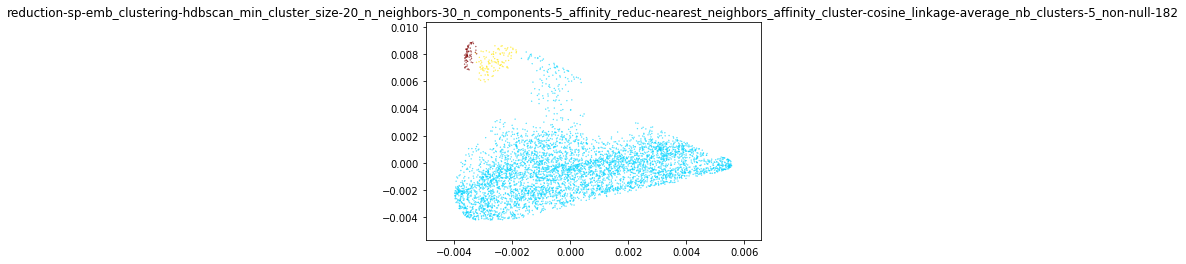

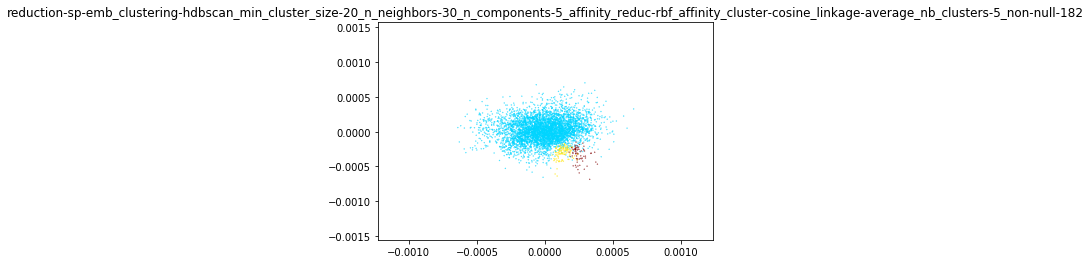

reduction_method:  sp-emb - clustering_method: hdbscan
min_samples: 1 - min_cluster_size: 30 - cluster_selection_epsilon: 0.5
n_neighbors: 30 - min_dist: 0.0 - n_components: 10 - n_clusters: 3


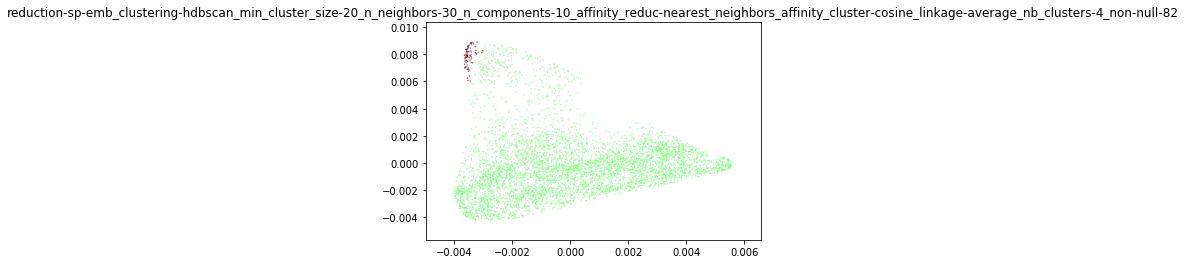

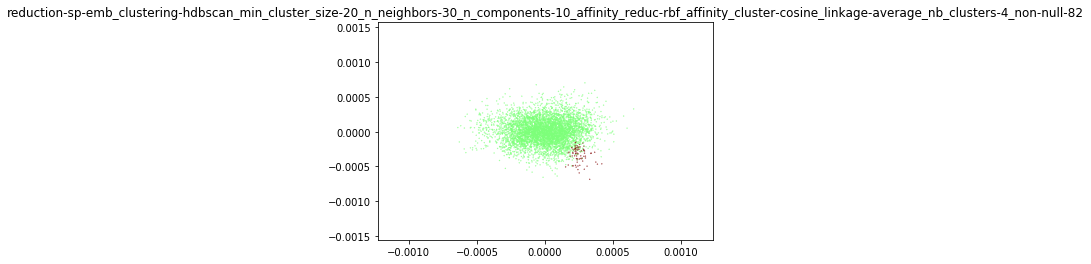

reduction_method:  sp-emb - clustering_method: hdbscan
min_samples: 1 - min_cluster_size: 30 - cluster_selection_epsilon: 0.5
n_neighbors: 30 - min_dist: 0.0 - n_components: 10 - n_clusters: 6


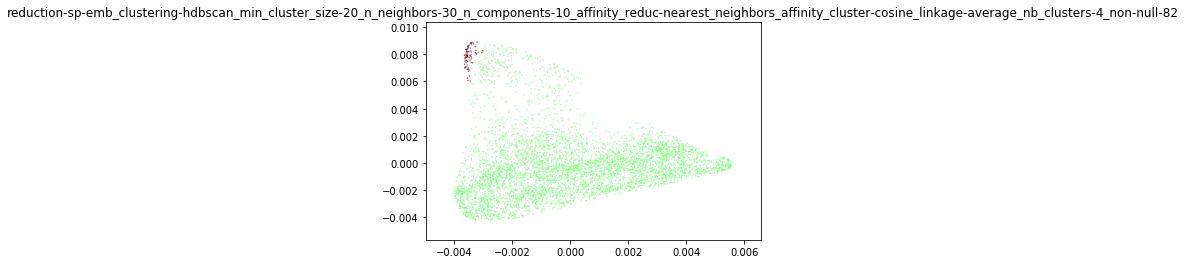

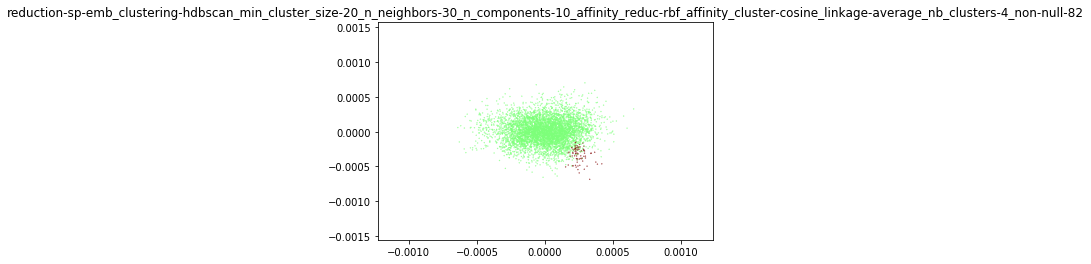

reduction_method:  sp-emb - clustering_method: hdbscan
min_samples: 1 - min_cluster_size: 30 - cluster_selection_epsilon: 0.5
n_neighbors: 30 - min_dist: 0.0 - n_components: 10 - n_clusters: 9


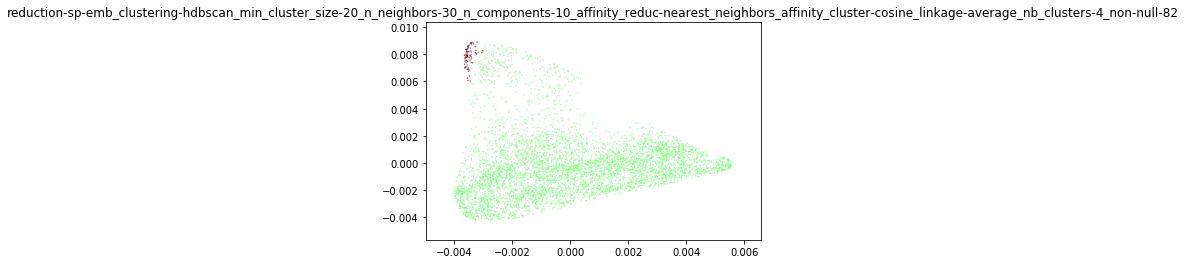

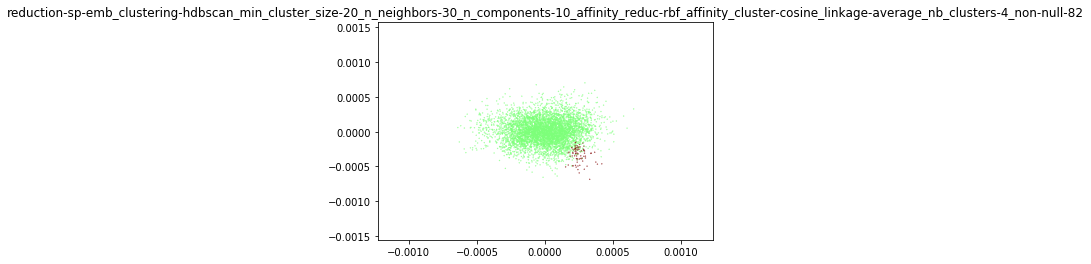

reduction_method:  sp-emb - clustering_method: hdbscan
min_samples: 1 - min_cluster_size: 30 - cluster_selection_epsilon: 0.5
n_neighbors: 30 - min_dist: 0.0 - n_components: 13 - n_clusters: 3


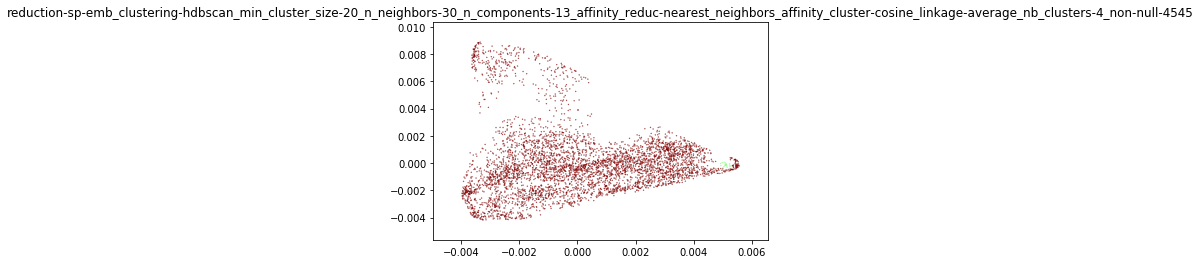

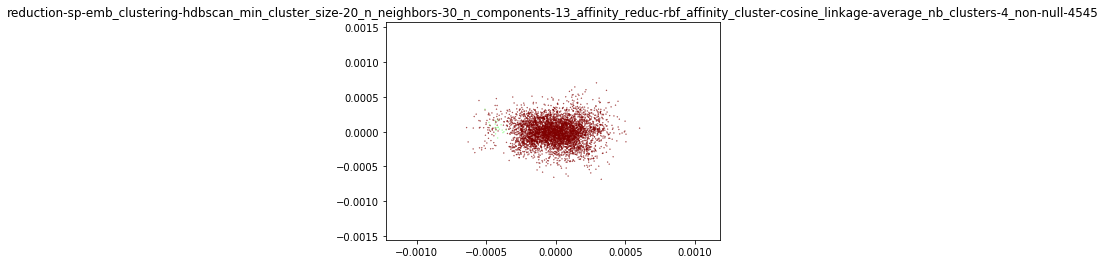

reduction_method:  sp-emb - clustering_method: hdbscan
min_samples: 1 - min_cluster_size: 30 - cluster_selection_epsilon: 0.5
n_neighbors: 30 - min_dist: 0.0 - n_components: 13 - n_clusters: 6


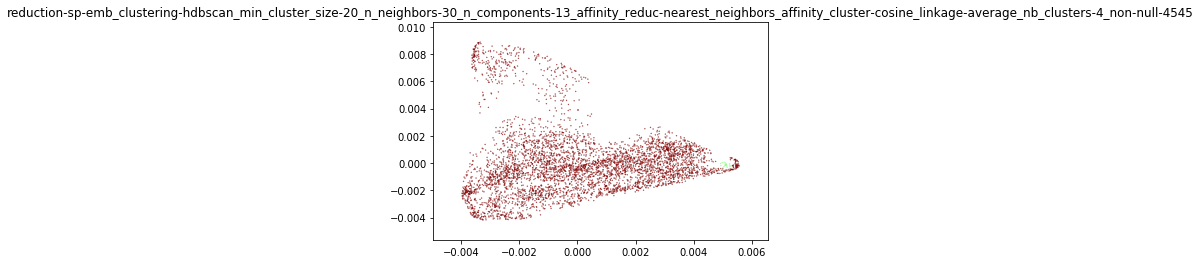

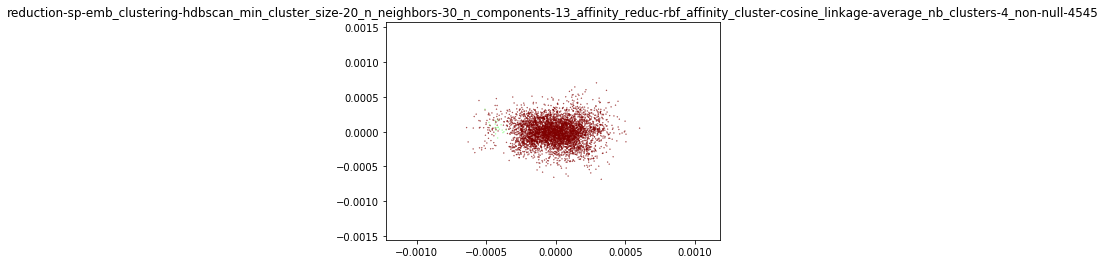

reduction_method:  sp-emb - clustering_method: hdbscan
min_samples: 1 - min_cluster_size: 30 - cluster_selection_epsilon: 0.5
n_neighbors: 30 - min_dist: 0.0 - n_components: 13 - n_clusters: 9


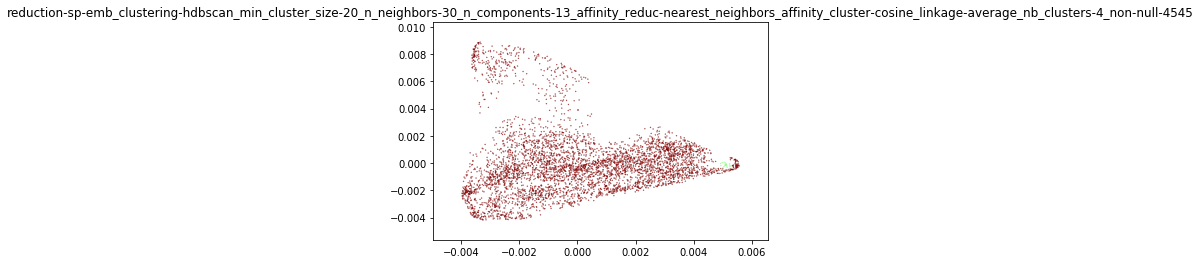

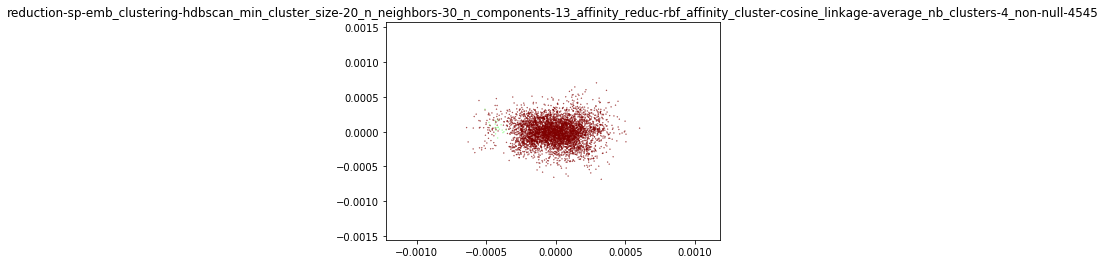

reduction_method:  sp-emb - clustering_method: agg-clus
min_samples: 1 - min_cluster_size: 30 - cluster_selection_epsilon: 0.5
n_neighbors: 30 - min_dist: 0.0 - n_components: 5 - n_clusters: 3


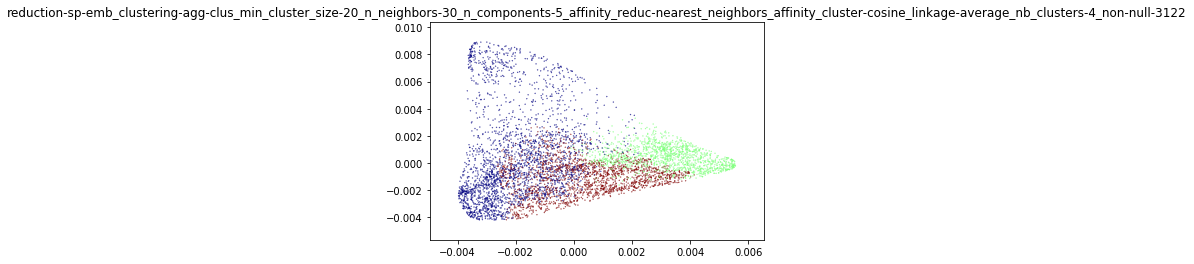

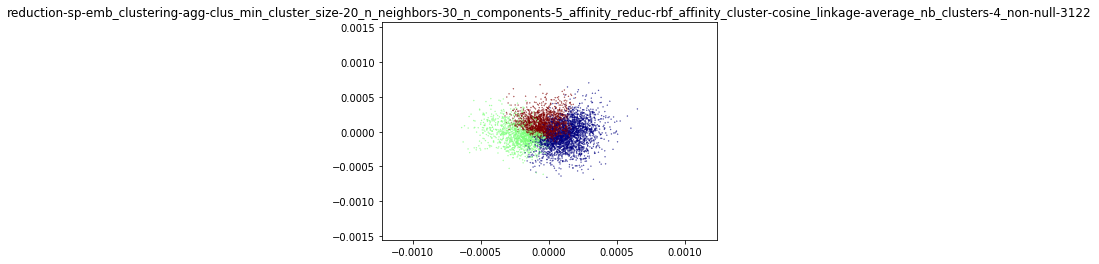

reduction_method:  sp-emb - clustering_method: agg-clus
min_samples: 1 - min_cluster_size: 30 - cluster_selection_epsilon: 0.5
n_neighbors: 30 - min_dist: 0.0 - n_components: 10 - n_clusters: 3


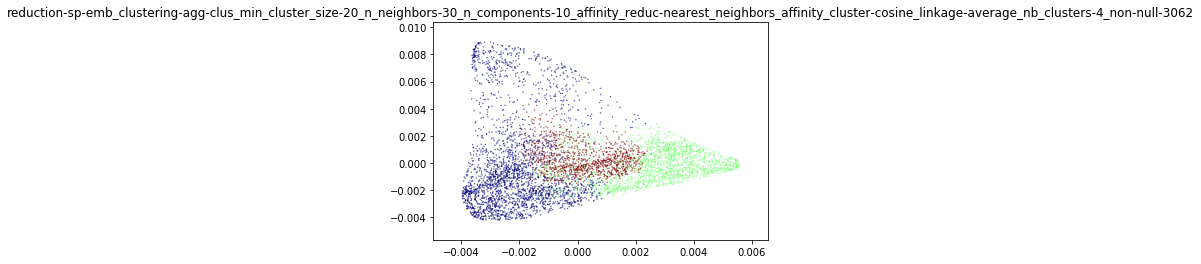

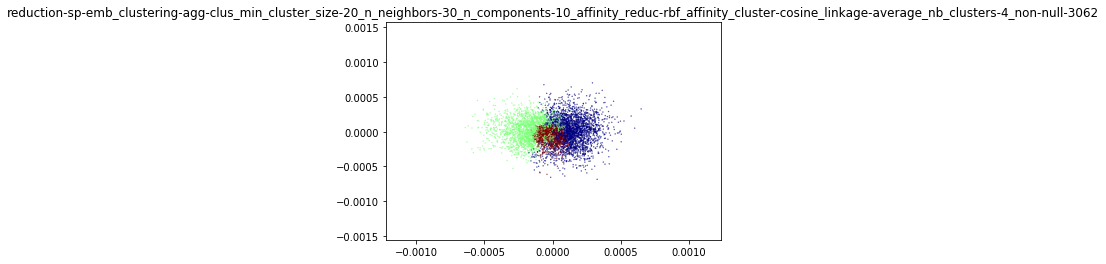

reduction_method:  sp-emb - clustering_method: agg-clus
min_samples: 1 - min_cluster_size: 30 - cluster_selection_epsilon: 0.5
n_neighbors: 30 - min_dist: 0.0 - n_components: 10 - n_clusters: 6


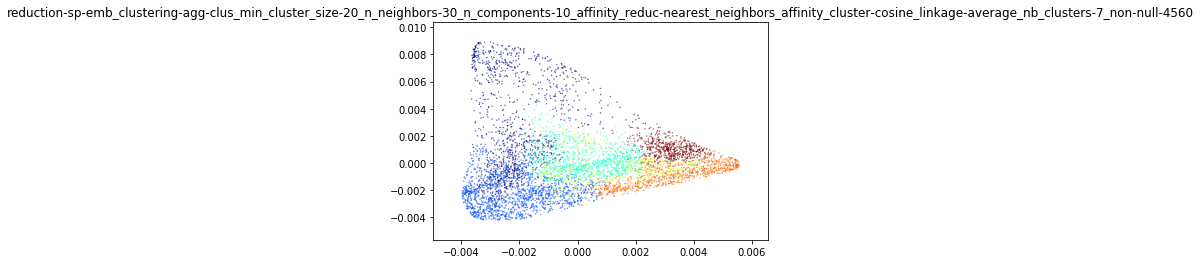

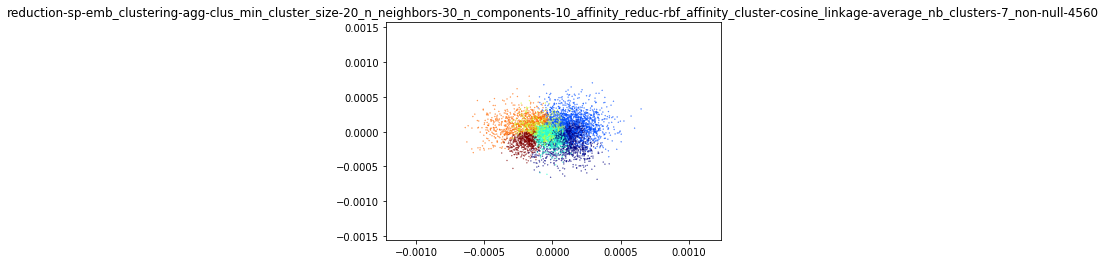

reduction_method:  sp-emb - clustering_method: agg-clus
min_samples: 1 - min_cluster_size: 30 - cluster_selection_epsilon: 0.5
n_neighbors: 30 - min_dist: 0.0 - n_components: 10 - n_clusters: 9


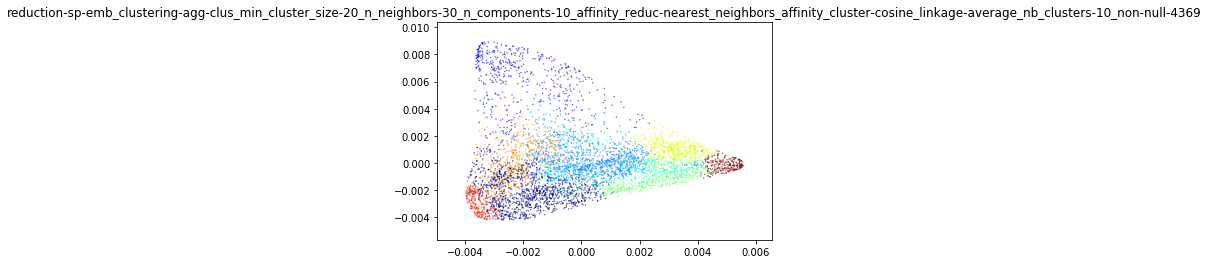

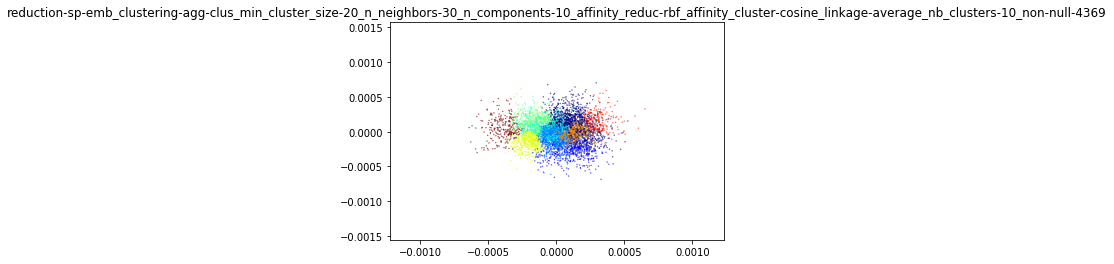

reduction_method:  sp-emb - clustering_method: agg-clus
min_samples: 1 - min_cluster_size: 30 - cluster_selection_epsilon: 0.5
n_neighbors: 30 - min_dist: 0.0 - n_components: 13 - n_clusters: 3


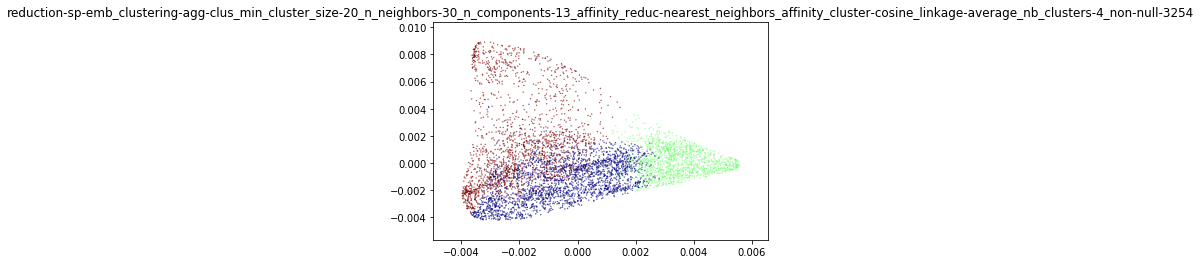

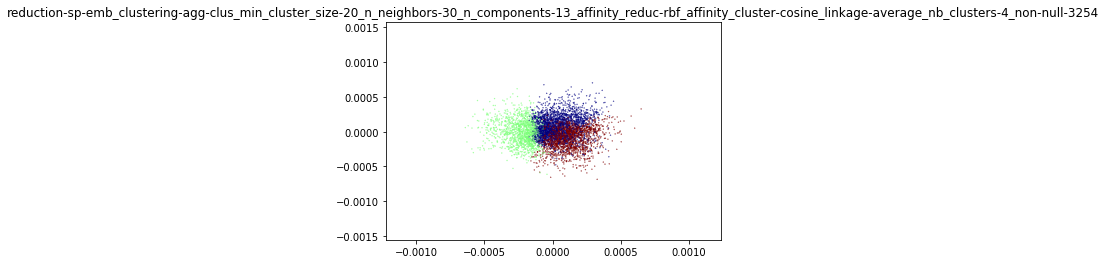

reduction_method:  sp-emb - clustering_method: agg-clus
min_samples: 1 - min_cluster_size: 30 - cluster_selection_epsilon: 0.5
n_neighbors: 30 - min_dist: 0.0 - n_components: 13 - n_clusters: 6


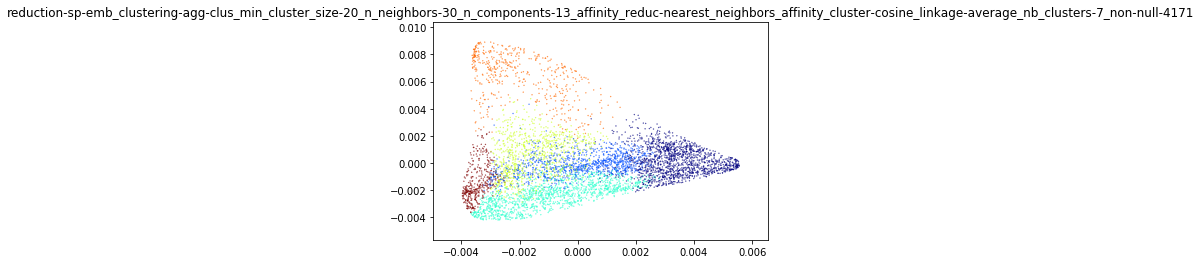

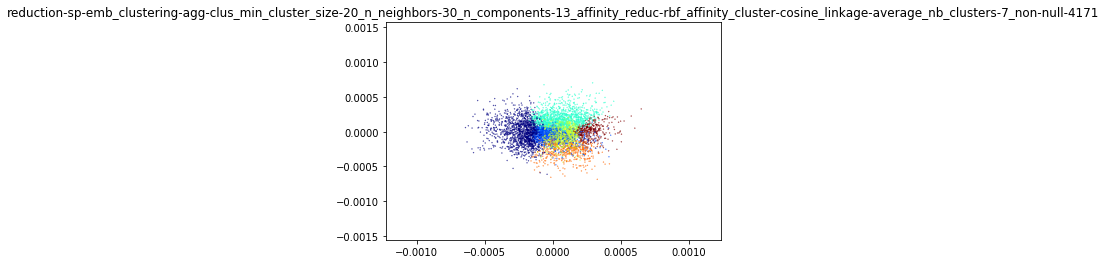

reduction_method:  sp-emb - clustering_method: agg-clus
min_samples: 1 - min_cluster_size: 30 - cluster_selection_epsilon: 0.5
n_neighbors: 30 - min_dist: 0.0 - n_components: 13 - n_clusters: 9


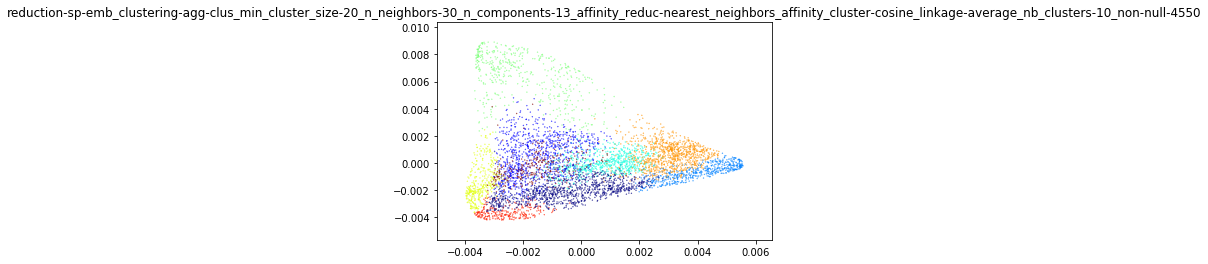

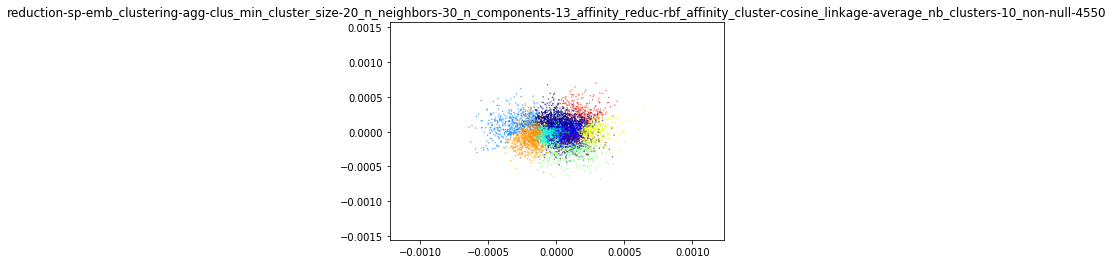

reduction_method:  sp-emb - clustering_method: max
min_samples: 1 - min_cluster_size: 30 - cluster_selection_epsilon: 0.5
n_neighbors: 30 - min_dist: 0.0 - n_components: 5 - n_clusters: 3


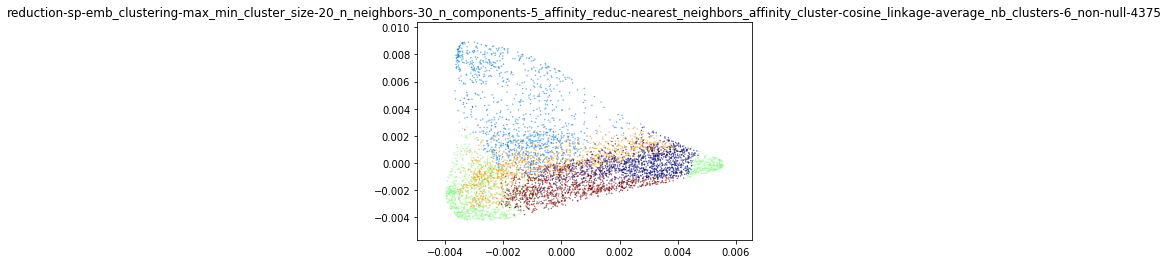

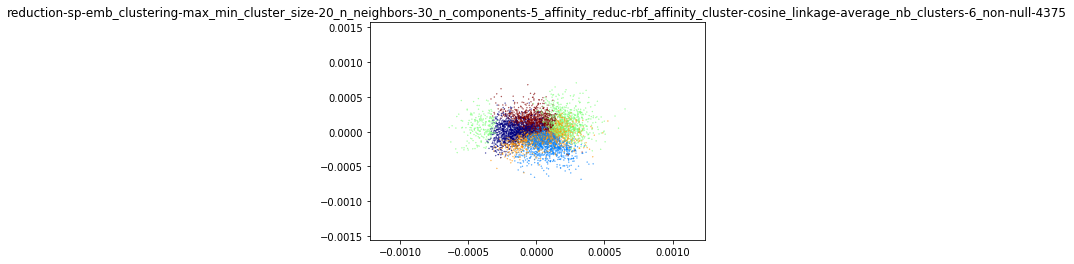

reduction_method:  sp-emb - clustering_method: max
min_samples: 1 - min_cluster_size: 30 - cluster_selection_epsilon: 0.5
n_neighbors: 30 - min_dist: 0.0 - n_components: 10 - n_clusters: 3


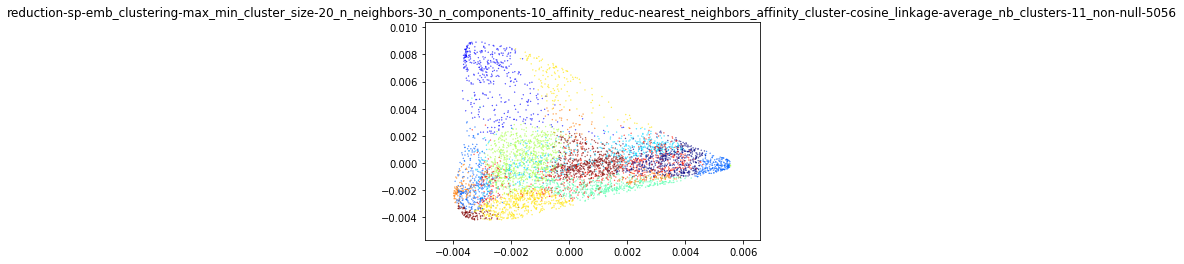

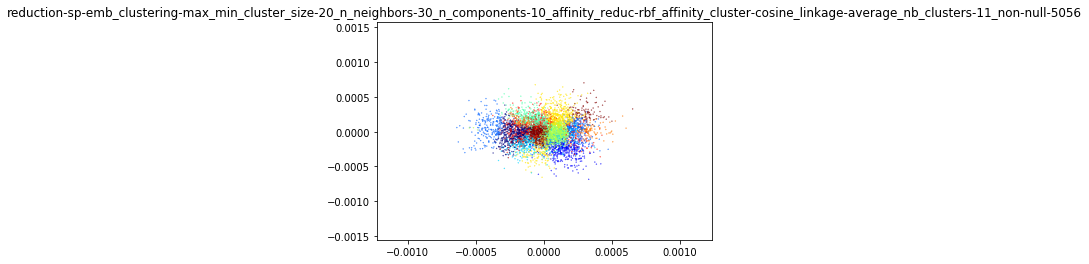

reduction_method:  sp-emb - clustering_method: max
min_samples: 1 - min_cluster_size: 30 - cluster_selection_epsilon: 0.5
n_neighbors: 30 - min_dist: 0.0 - n_components: 10 - n_clusters: 6


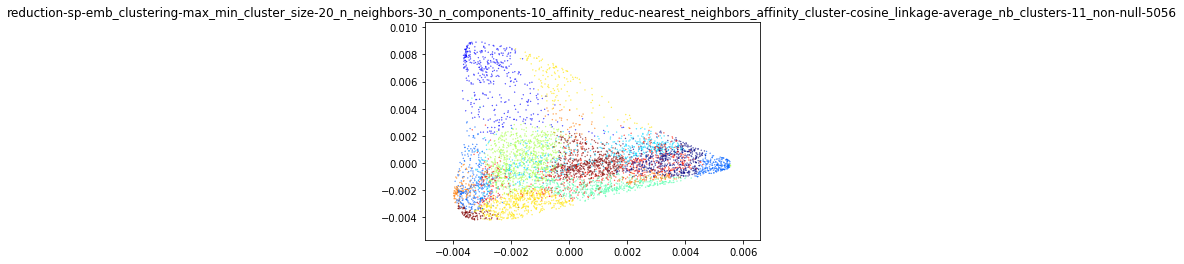

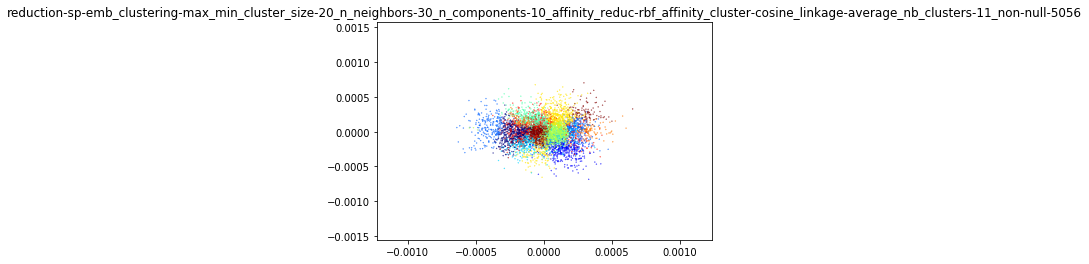

reduction_method:  sp-emb - clustering_method: max
min_samples: 1 - min_cluster_size: 30 - cluster_selection_epsilon: 0.5
n_neighbors: 30 - min_dist: 0.0 - n_components: 10 - n_clusters: 9


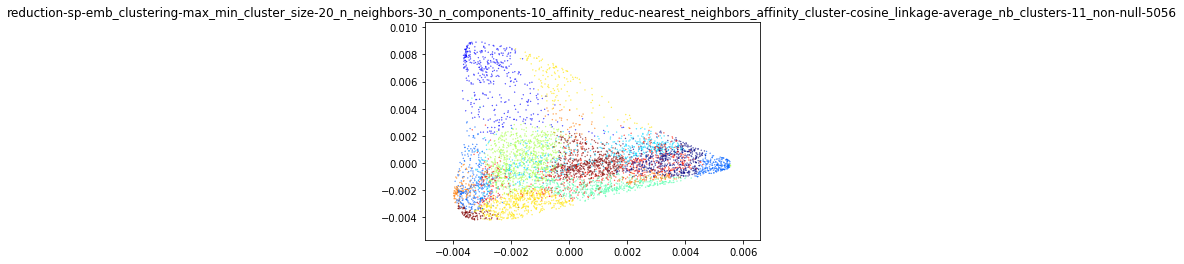

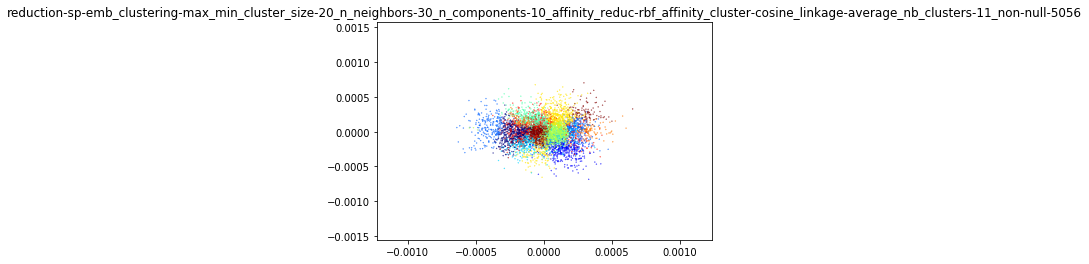

reduction_method:  sp-emb - clustering_method: max
min_samples: 1 - min_cluster_size: 30 - cluster_selection_epsilon: 0.5
n_neighbors: 30 - min_dist: 0.0 - n_components: 13 - n_clusters: 3


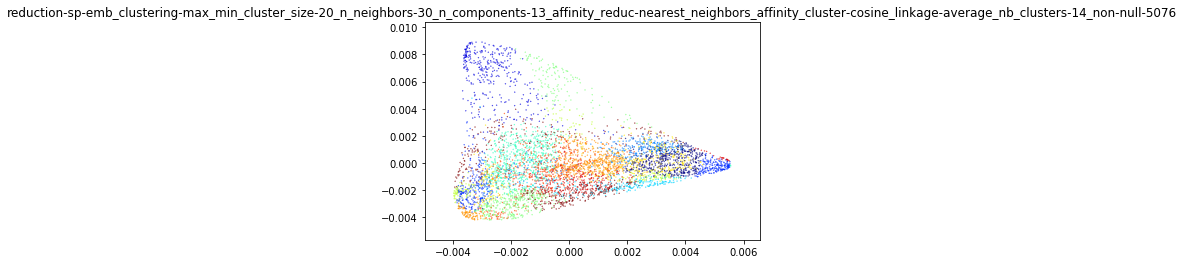

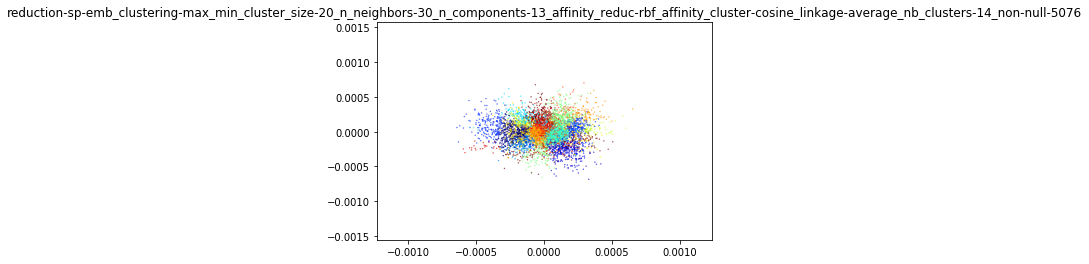

reduction_method:  sp-emb - clustering_method: max
min_samples: 1 - min_cluster_size: 30 - cluster_selection_epsilon: 0.5
n_neighbors: 30 - min_dist: 0.0 - n_components: 13 - n_clusters: 6


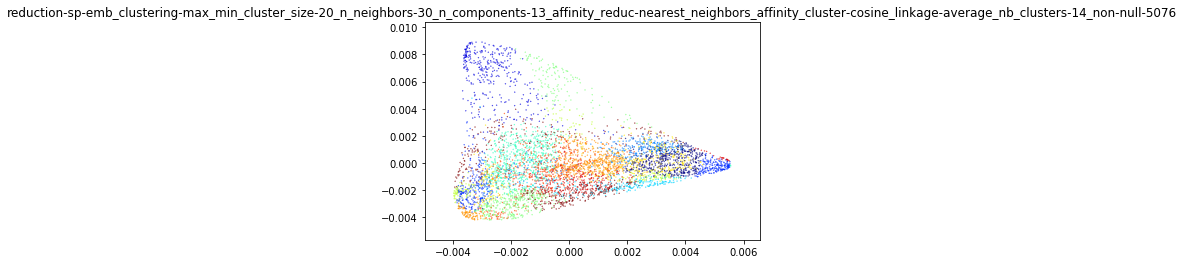

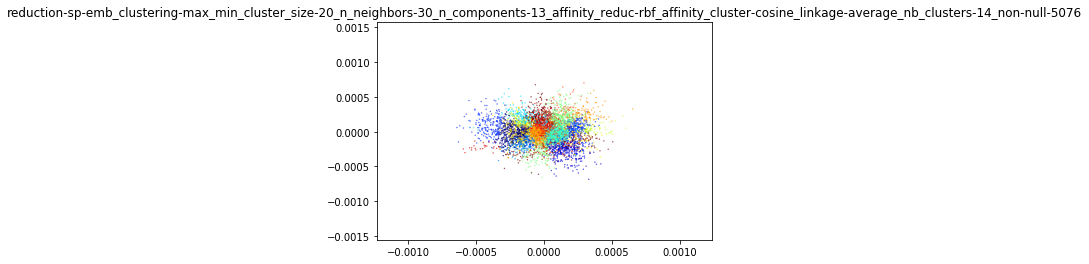

reduction_method:  sp-emb - clustering_method: max
min_samples: 1 - min_cluster_size: 30 - cluster_selection_epsilon: 0.5
n_neighbors: 30 - min_dist: 0.0 - n_components: 13 - n_clusters: 9


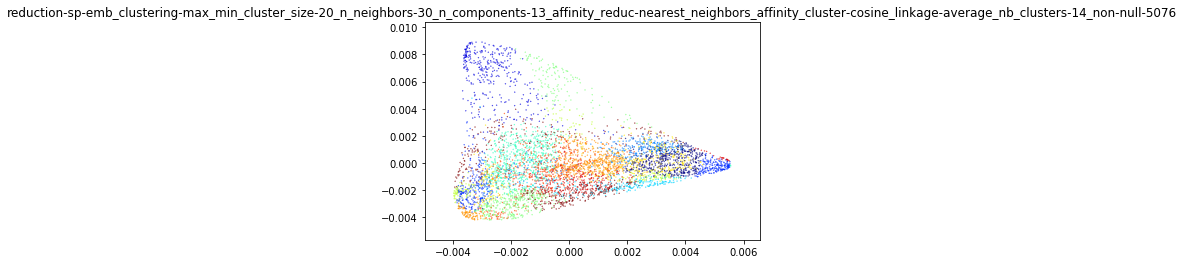

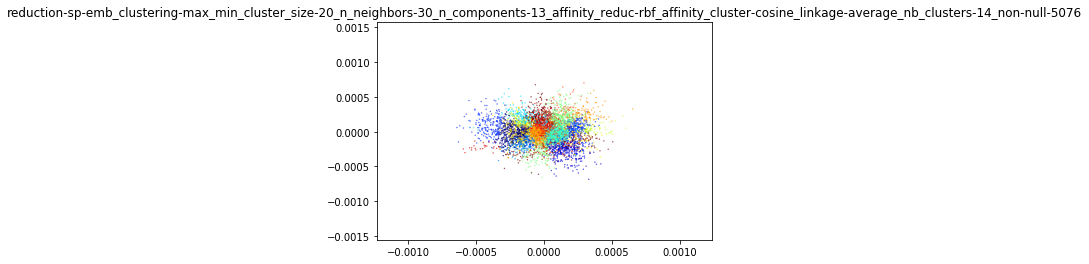

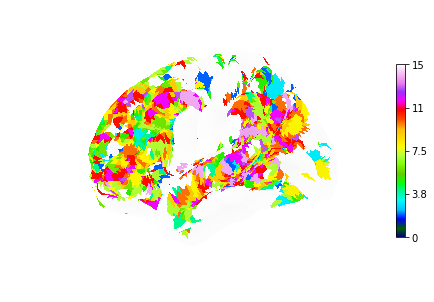

In [173]:
params.update({'path_to_beta_maps': resample_beta_maps(aggregate_beta_maps(path_to_beta_maps, nb_layers=13, layer_size=768), original_masker, new_masker),
              'mask': mask})

for reduction_method in ["sp-emb"]:
    for clustering_method in all_clustering_method:
        params.update({'saving_folder': os.path.join(saving_folder, '_'.join([reduction_method, clustering_method]) + '/')})
        for n_components in n_components_list:
            for n_clusters in n_clusters_list:
                if n_components > n_clusters:
                    params.update({'reduction':reduction_method,
                                   'clustering':clustering_method, 
                                   'n_components':n_components,
                                   'n_clusters':n_clusters,
                                  })
                    print("reduction_method: ", reduction_method, '- clustering_method:', clustering_method)
                    print('min_samples:', min_samples, '- min_cluster_size:', min_cluster_size, '- cluster_selection_epsilon:', cluster_selection_epsilon)
                    print('n_neighbors:', n_neighbors, '- min_dist:', min_dist, '- n_components:', n_components, '- n_clusters:', n_clusters)
                    if reduction_method=="sp-emb":
                        for affinity_reduc in affinity_list_SE:
                            params.update({'affinity_reduc': affinity_reduc})
                            if clustering_method=="AgglomerativeClustering":
                                for linkage in linkage_list:
                                    if linkage!='ward':
                                        for affinity_cluster in affinity_list_AC:
                                            params.update({'affinity_cluster': affinity_cluster, 'linkage': linkage})
                                            plot_name = create_name(subject_name, params)
                                            params.update({'plot_name': plot_name})
                                            results = clustering(**params)
                                            save_results(results, params['saving_folder'], plot_name, global_masker_95, mask, **kwargs)
                                    else:
                                        params.update({'affinity_cluster': "euclidean", 'linkage': linkage})
                                        plot_name = create_name(subject_name, params)
                                        params.update({'plot_name': plot_name})
                                        results = clustering(**params)
                                        save_results(results, params['saving_folder'], plot_name, global_masker_95, mask, **kwargs)
                            else:
                                plot_name = create_name(subject_name, params)
                                params.update({'plot_name': plot_name})
                                results = clustering(**params)
                                save_results(results, params['saving_folder'], plot_name, global_masker_95, mask, **kwargs)
                    else:
                        if clustering_method=="AgglomerativeClustering":
                            for linkage in linkage_list:
                                if linkage!='ward':
                                    for affinity_cluster in affinity_list_AC:
                                        params.update({'affinity_cluster': affinity_cluster, 
                                                       'linkage': linkage})
                                        plot_name = create_name(subject_name, params)
                                        params.update({'plot_name': plot_name})
                                        results = clustering(**params)
                                        save_results(results, params['saving_folder'], plot_name, global_masker_95, mask, **kwargs)
                                else:
                                    params.update({'affinity_cluster': "euclidean", 'linkage': linkage})
                                    plot_name = create_name(subject_name, params)
                                    params.update({'plot_name': plot_name})
                                    results = clustering(**params)
                                    save_results(results, params['saving_folder'], plot_name, global_masker_95, mask, **kwargs)
                        else:
                            plot_name = create_name(subject_name, params)
                            params.update({'plot_name': plot_name})
                            results = clustering(**params)
                            save_results(results, params['saving_folder'], plot_name, global_masker_95, mask, **kwargs)
                            

## Average atlas

In [209]:
parameters = {
        'reduction': 'umap', 
        'clustering': 'AgglomerativeClustering', 
        'min_cluster_size':20, 
        'min_samples':10, 
        'n_neighbors':30, 
        'min_dist':0.0, 
        'n_components':10, 
        'n_clusters':13, 
        'random_state':1111, 
        'cluster_selection_epsilon':0.0, 
        'affinity_reduc' : 'nearest_neighbors',
        'affinity_cluster':'cosine', 
        'linkage':'average'
}
prob_matrices = []

for subject in subjects:
    #path = get_labels(subject_name, parameters['reduction'], parameters['clustering'], saving_folder, parameters)[0]
    path = glob.glob('/Users/alexpsq/Code/Parietal/maps/umap_AgglomerativeClustering/labels/reduction_method-umap_clustering_method-AgglomerativeClustering_min_cluster_size-20_n_neighbors-30_n_components-10_affinity_reduc-nearest_neighbors_affinity_cluster-cosine_linkage-average*7*.npy')[0]
    labels = np.load(path)
    prob_matrices.append(get_prob_matrix(labels))

In [210]:
matrix_ = np.stack(prob_matrices, axis=0)
matrix = np.mean(matrix_, axis=0)

In [ ]:
rois = np.argmax(matrix, axis=0)

In [213]:
final_matrix = np.zeros((len(np.unique(rois)), len(rois)))
for index, i in enumerate(rois):
    final_matrix[i, index] = 1

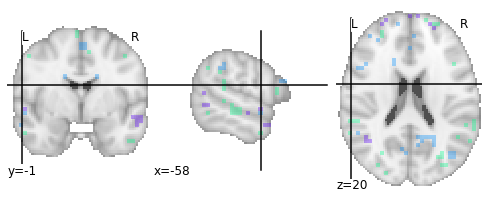

In [220]:
plotting.plot_prob_atlas(
    global_masker_95.inverse_transform(final_matrix), 
    display_mode='ortho', 
    colorbar=False,
    cut_coords=(-58,-1, 20))
plotting.show()

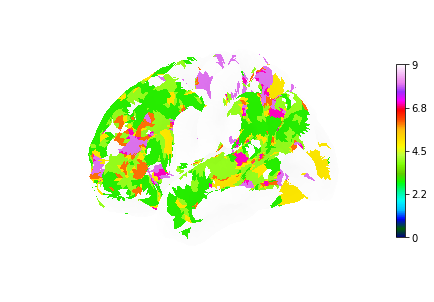

In [223]:
img = global_masker_95.inverse_transform(rois)
plot_roi_img_surf(img, 'None', 'plot_name', mask=global_masker_95.inverse_transform(mask), labels=np.unique(rois), inflated=False, compute_surf=True, colorbar=True, **kwargs)


## Visualization

In [ ]:
%matplotlib notebook
from ipywidgets import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib


plot_reduc(
            aggregate_beta_maps(path_to_beta_maps, nb_layers=13, layer_size=768), 
            )